## From CSV File: Stop and Frisk / NYPD

In [ ]:
# Let's grab the csv file ('wget'), unzip it, and change its name to something that doesn't include spaces.
# SSH into your remote machine and run the following commands:

''' 
    cd /class/itpmssd/datasets
    wget http://www.nyclu.org/files/stopandfrisk/Stop-and-Frisk-2012.zip
    unzip Stop-and-Frisk-2012.zip
    mv SQF\ 2012.csv sf2012.csv
'''

#### Now let's explore the dataset using the command line first

In [1]:
# Now we can open the file
import seaborn as sns
import pandas as pd

path = '/class/itpmssd/datasets/sf2012_sm.csv'
df = pd.read_csv(path, low_memory=False)

In [2]:
# different ways to look at the data (since it is way too large to simply print)

df.head()

,year,pct,ser_num,datestop,timestop,city,sex,race,dob,age,...,revcmd,offunif,offverb,officrid,offshld,ac_rept,ac_inves,radio,recstat,linecm
0,2012,40,17,1012012,115,3,1,1,12311900,20,...,40,1,0,0,0,0,1,0,1,1
1,2012,23,691,1012012,310,1,1,3,12311900,18,...,23,1,0,0,0,0,0,1,1,1
2,2012,81,3714,1012012,2000,2,1,1,12311900,19,...,81,1,0,0,0,0,1,0,1,1
3,2012,81,633,1022012,1245,2,1,1,12311900,37,...,81,1,0,0,0,0,0,1,1,1
4,2012,66,36,1042012,2220,2,1,3,5211990,21,...,72,0,0,0,1,0,1,0,A,1


In [3]:
df.tail(4)

,year,pct,ser_num,datestop,timestop,city,sex,race,dob,age,...,revcmd,offunif,offverb,officrid,offshld,ac_rept,ac_inves,radio,recstat,linecm
532907,2012,123,1950,11042012,1930,5,0,4,4091990,22,...,123,1,0,0,0,0,1,0,A,1
532908,2012,123,1951,11042012,2305,5,1,4,2161995,17,...,123,1,0,0,0,0,1,0,A,1
532909,2012,123,1952,11042012,2305,5,1,4,2121994,18,...,123,1,0,0,0,0,1,0,A,1
532910,2012,123,1953,11082012,2113,5,1,4,11261994,18,...,123,1,0,0,0,0,1,0,A,1


In [4]:
df[900:905]

,year,pct,ser_num,datestop,timestop,city,sex,race,dob,age,...,revcmd,offunif,offverb,officrid,offshld,ac_rept,ac_inves,radio,recstat,linecm
900,2012,81,5,1012012,410,2,1,1,7041981,30,...,165,1,0,0,0,0,0,0,1,1
901,2012,71,44,1012012,410,2,1,1,12311900,25,...,71,1,0,0,0,0,0,0,A,1
902,2012,90,1,1012012,410,2,1,3,4161988,23,...,90,1,0,0,0,0,0,0,A,1
903,2012,30,89,1012012,410,1,1,3,12191989,22,...,516,1,0,0,0,0,0,0,A,1
904,2012,7,9,1012012,410,1,1,4,6281974,35,...,7,1,0,0,0,0,0,0,A,1


In [5]:
len(df)

532911

### Cleaning the Data

In [6]:
import datetime

# translate the messy date string into something cleaner -> a datetime structure
# (M)MDDYYYY

def parse_hour(timestop):
    minute = timestop % 100
    hour = timestop / 100
    return hour,minute

def parse_date(datestop):
    month = int(str(datestop)[:-6])
    day = int(str(datestop)[-6:-4])
    year = int(str(datestop)[-4:])
    return year, month, day

def make_datetime(datestop, timestop):
    year, month, day = parse_date(datestop)
    hour, minute = parse_hour(timestop)
    return datetime.datetime(year, month, day, hour)

def make_date(datestop):
    year, month, day = parse_date(datestop)
    return datetime.datetime(year, month, day)

In [7]:
df.ix[0].datestop

1012012

In [8]:
print parse_date(df.ix[0].datestop)
print parse_hour(df.ix[0].timestop)
print make_datetime(df.ix[0].datestop, df.ix[0].timestop)
print make_date(df.ix[0].datestop)

(2012, 1, 1)
(1, 15)
2012-01-01 01:00:00
2012-01-01 00:00:00


In [9]:
# now lets add a parsed datetime row in our data frame - by applying the function that we've just built
# this will give us a 'dt' field we can use to group by

df['dt']=df[['datestop','timestop']].apply(lambda x: make_datetime(x['datestop'], x['timestop']), axis=1)
df['d']=df[['datestop']].apply(lambda x: make_date(x['datestop']), axis=1)

In [10]:
df.tail()

,year,pct,ser_num,datestop,timestop,city,sex,race,dob,age,...,offverb,officrid,offshld,ac_rept,ac_inves,radio,recstat,linecm,dt,d
532906,2012,123,1949,11042012,1930,5,1,4,7101991,21,...,0,0,0,0,1,0,A,1,2012-11-04 19:00:00,2012-11-04
532907,2012,123,1950,11042012,1930,5,0,4,4091990,22,...,0,0,0,0,1,0,A,1,2012-11-04 19:00:00,2012-11-04
532908,2012,123,1951,11042012,2305,5,1,4,2161995,17,...,0,0,0,0,1,0,A,1,2012-11-04 23:00:00,2012-11-04
532909,2012,123,1952,11042012,2305,5,1,4,2121994,18,...,0,0,0,0,1,0,A,1,2012-11-04 23:00:00,2012-11-04
532910,2012,123,1953,11082012,2113,5,1,4,11261994,18,...,0,0,0,0,1,0,A,1,2012-11-08 21:00:00,2012-11-08


### Grouping: split-apply-combine

In [11]:
# Grouping - counting the number of reported incidents per hour (can also do grouped.count())

daily_incidents = df.groupby(df.dt).size()

In [12]:
daily_incidents.sort()
print daily_incidents[-10:]

dt
2012-02-10 21:00:00    262
2012-01-06 20:00:00    263
2012-03-09 19:00:00    268
2012-03-02 19:00:00    270
2012-01-06 19:00:00    270
2012-02-10 20:00:00    277
2012-01-06 21:00:00    278
2012-03-16 22:00:00    280
2012-01-06 22:00:00    285
2012-03-10 20:00:00    303
dtype: int64


Populating the interactive namespace from numpy and matplotlib


/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1236: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)
/usr/lib/pymodules/python2.7/matplotlib/font_manager.py:1246: UserWarning: findfont: Could not match :family=Bitstream Vera Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=11.0. Returning /usr/share/matplotlib/mpl-data/fonts/ttf/cmb10.ttf
  UserWarning)


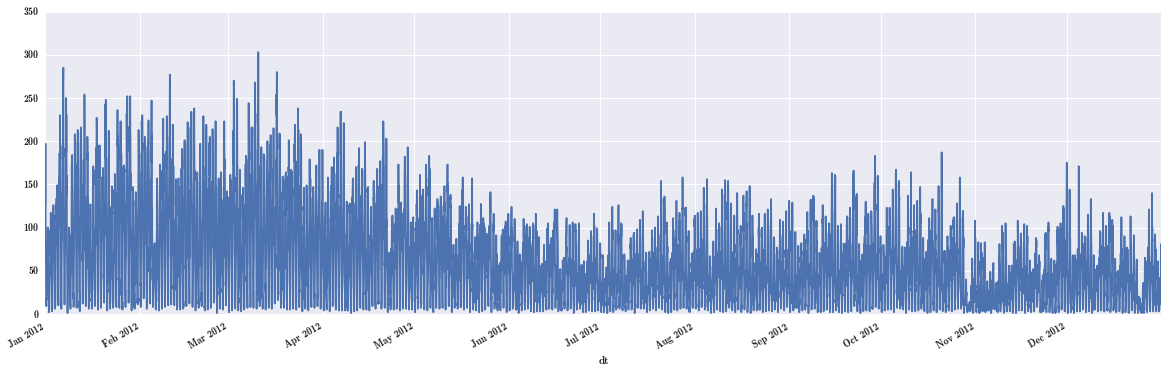

In [13]:
# let's make a plot - that shows trends over time
%pylab inline

df.groupby(df.dt).size().plot(figsize=(20,6))

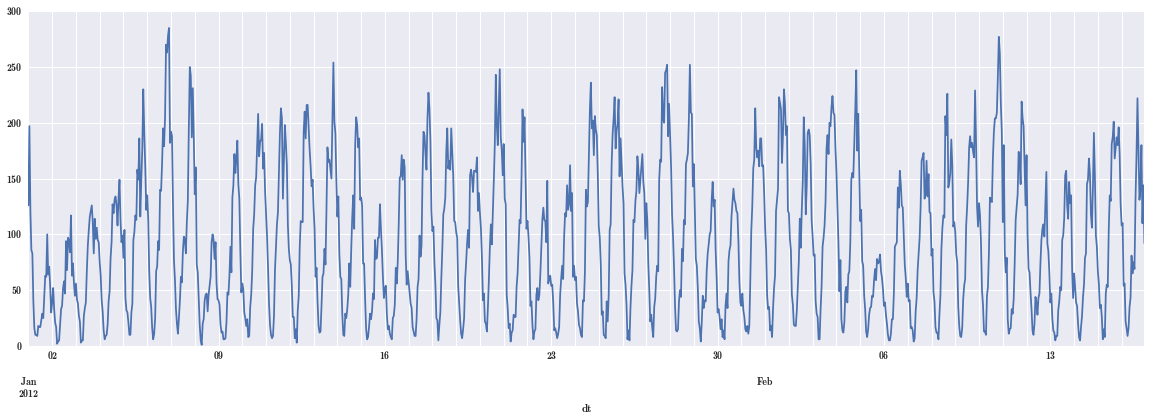

In [14]:
# we can easily specify a smaller date range
df.groupby(df.dt).size()[:'2012-02-16'].plot(figsize=(20,6))

### Let's examine age

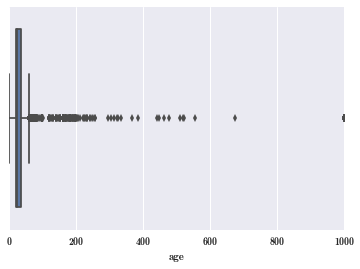

In [23]:
# apparently immortality is imminent

sns.boxplot(df.age)

In [ ]:
# DRAAAAATS - more weirdnesses in the data!

In [24]:
# argmax prints the row # for the maximum value in a given column
print 'maximum age index number:',df.age.argmax(),'\n'

maximum age index number: 1021 



In [25]:
# ix[] -> is a way to access values given a specific row
print 'maximum age row:',df.ix[1021]

maximum age row: year                       2012
pct                          67
ser_num                      26
datestop                1012012
timestop                    728
city                          2
sex                           1
race                          1
dob                    12311900
age                         999
height                       68
weight                      190
haircolr                      1
eyecolor                      2
build                         3
othfeatr                    NaN
frisked                       1
searched                      0
contrabn                      0
pistol                        0
riflshot                      0
asltweap                      0
knifcuti                      0
machgun                       0
othrweap                      0
arstmade                      0
arstoffn                    NaN
sumissue                      0
sumoffen                    NaN
crimsusp                    FEL
                   ... 

In [26]:
# How bad is it? How many rows in our data have weird age figures?
MAX_AGE = 100

print 'number of problematic rows:',len(df[[a>MAX_AGE for a in df.age]])

# 0.2% of our data is problematic
len(df[[a>MAX_AGE for a in df.age]])/float(len(df))


number of problematic rows: 195


0.001950019500195002

In [27]:
# filter out rows with faulty age info
df = df[[x<MAX_AGE for x in df.age]]

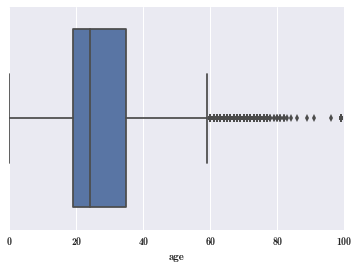

In [28]:
# Let's try this again
sns.boxplot(df.age)

### Filter out Columns

In [6]:
# we can always get rid of unnecessary columns - makes DataFrames easier to handle

wanted_columns = ['dt','d','age','sex','race','height','weight','build','frisked']

sm_df = df[wanted_columns]
sm_df.head()

,dt,d,age,sex,race,height,weight,build,frisked
0,2012-01-01 01:00:00,2012-01-01,20,1,1,69,155,4,1
1,2012-01-01 03:00:00,2012-01-01,18,1,3,67,175,3,0
2,2012-01-01 20:00:00,2012-01-01,19,1,1,69,180,3,0
3,2012-01-02 12:00:00,2012-01-02,37,1,1,65,210,1,0
4,2012-01-04 22:00:00,2012-01-04,21,1,3,67,170,3,0


### Now let's take a look at Race

In [30]:
race_labels = {
    1:'black', 
    2:'black_Hispanic', 
    3:'white_Hispanic', 
    4:'white', 
    5:'Asian_Pacific_Islander', 
    6:'Am_Indian_Native_Alaskan'
}

In [7]:
sm_df.race[10:20]

10    1
11    1
12    1
13    1
14    1
15    1
16    4
17    3
18    1
19    1
Name: race, dtype: float64

In [32]:
# we can use our handy dictionary to apply the labels
[race_labels[x] for x in sm_df.race[10:20]]

['black',
 'black',
 'black',
 'black',
 'black',
 'black',
 'white',
 'white_Hispanic',
 'black',
 'black']

In [9]:
# Handy way to count values in a column

sm_df.race.value_counts()

1    52877
3    25159
4     8836
2     6997
5     3077
6      420
dtype: int64

Populating the interactive namespace from numpy and matplotlib


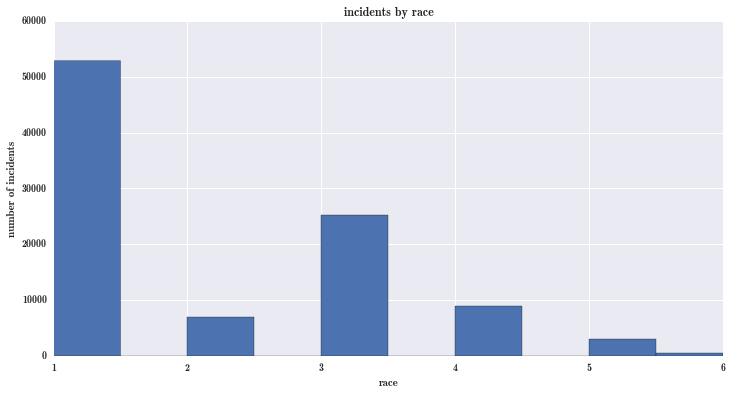

In [13]:
%pylab inline

# histogram: show entries by race
sm_df.race.hist(figsize=(12,6))
ylabel('number of incidents')
xlabel('race')
title('incidents by race')

In [14]:
grouped = sm_df.groupby('race')
black = grouped.get_group(1)
white_hispanic = grouped.get_group(3)
white = grouped.get_group(4)

In [15]:
black.describe()

,age,sex,race,height,weight,build,frisked
count,52877.000000,52600.000000,52877,52877.000000,52877.000000,52286.000000,52877.000000
mean,28.972635,0.929734,1,69.059553,171.098795,3.163619,0.568073
std,28.490984,0.255597,0,3.203028,42.901161,0.799580,0.495349
min,0.000000,0.000000,1,36.000000,0.000000,1.000000,0.000000
25%,19.000000,1.000000,1,67.000000,150.000000,3.000000,0.000000
50%,24.000000,1.000000,1,69.000000,170.000000,3.000000,1.000000
75%,35.000000,1.000000,1,71.000000,185.000000,4.000000,1.000000
max,999.000000,1.000000,1,95.000000,999.000000,4.000000,1.000000


Populating the interactive namespace from numpy and matplotlib


array([[<matplotlib.axes.AxesSubplot object at 0x7f782cece350>,
        <matplotlib.axes.AxesSubplot object at 0x7f7827696650>]], dtype=object)

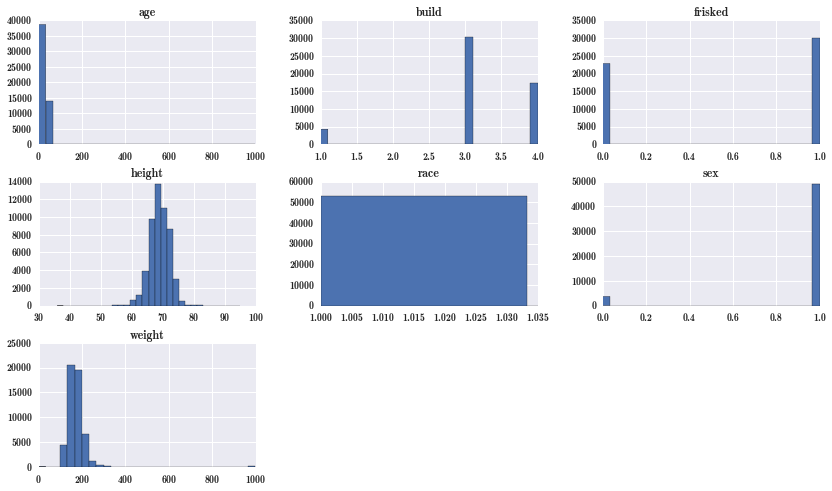

In [16]:
%pylab inline
grouped.get_group(1).hist(bins=30,figsize=(14,8))

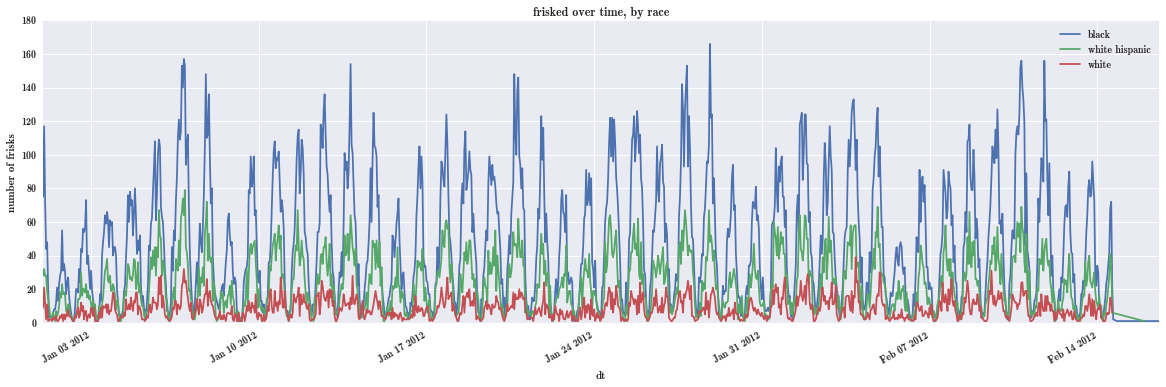

In [17]:
# plot frisks broken down by race over time
black.groupby('dt').frisked.size()[:'2012-02-16'].plot(figsize=(20,6), label='black')
white_hispanic.groupby('dt').frisked.size()[:'2012-02-16'].plot(figsize=(20,6), label='white hispanic')
white.groupby('dt').frisked.size()[:'2012-02-16'].plot(figsize=(20,6), label='white')
legend()
title('frisked over time, by race')
ylabel('number of frisks')

In [ ]:
# plot frisks broken down by race over time
black.groupby('dt').frisked.size()[:'2012-01-16'].plot(kind="bar",figsize=(20,6), label='black')
white_hispanic.groupby('dt').frisked.size()[:'2012-01-16'].plot(kind="bar",figsize=(20,6), label='white hispanic')
white.groupby('dt').frisked.size()[:'2012-01-16'].plot(kind="bar",figsize=(20,6), label='white')
legend()
title('frisked over time, by race')
ylabel('number of frisks')

In [ ]:
# multi-bar charts (note: they are overlayed on top of each other)

black.groupby('d').size()[:'2012-02-16'].plot(kind="bar", figsize=(20,6), label='black')
white_hispanic.groupby('d').size()[:'2012-02-16'].plot(kind="bar", color='red', figsize=(20,6), label='white_hispanic')
white.groupby('d').size()[:'2012-02-16'].plot(kind="bar", color='orange', figsize=(20,6), label='white')
xticks(rotation=45)
legend()
title('daily incidents, by race')

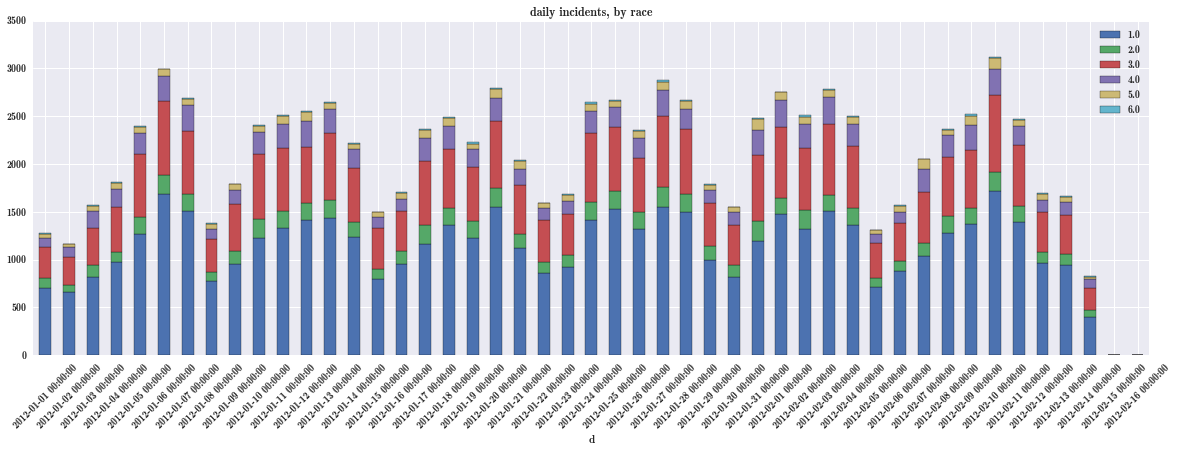

In [39]:
# stacked bar chart

sm_df.groupby(['d','race']).size()[:'2012-02-16'].unstack('race').plot(kind="bar", figsize=(20,6), stacked=True)

xticks(rotation=45)
legend()
title('daily incidents, by race')

In [ ]:
# frisked vs. not frisked - from the population of incidents involving black people

black.groupby(['d','frisked']).size()[:'2012-02-16'].unstack('frisked').plot(kind="bar", figsize=(18,6))
title('daily frisks, for race=black')

### Correlation

In [40]:
sm_df.corr()

,age,sex,race,height,weight,build,frisked
age,1.000000,0.001188,0.016392,0.073676,0.206114,-0.159466,-0.149275
sex,0.001188,1.000000,-0.019606,0.299459,0.158251,-0.006539,0.147609
race,0.016392,-0.019606,1.000000,-0.143102,-0.044890,0.003513,-0.060570
height,0.073676,0.299459,-0.143102,1.000000,0.360286,-0.129347,0.061372
weight,0.206114,0.158251,-0.044890,0.360286,1.000000,-0.426790,0.000555
build,-0.159466,-0.006539,0.003513,-0.129347,-0.426790,1.000000,0.017623
frisked,-0.149275,0.147609,-0.060570,0.061372,0.000555,0.017623,1.000000


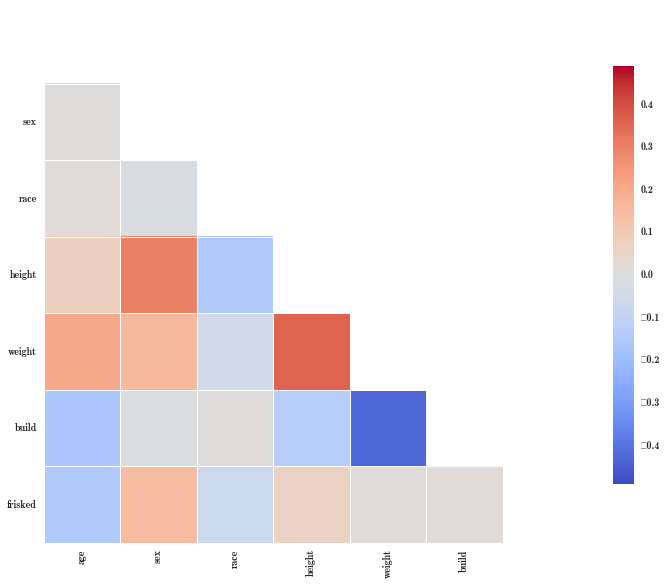

In [42]:
plt.subplots(figsize=(12, 10))
sns.corrplot(sm_df, annot=False, diag_names=False)

### Pickle the small DataFrame (for when our system crashes)

In [ ]:
# save the data for later
import pickle

f = open('/class/itpmssd/Week_2/sm_df.p','wb')
pickle.dump(sm_df,f)
f.close()

In [ ]:
# load the data from pickled file

pkl_file = open('/class/itpmssd/Week_2/sm_df.p','rb')
sm_df = pickle.load(pkl_file)

# ... aaand VOILA!

### Related Reads and References

- Precinct or Prejudice? understanding racial disparities in New York City's stop-and-frisk policy: https://5harad.com/papers/frisky.pdf
